In [1]:
from screenTools import *


In [30]:
from os import listdir

folder = "./data/"
datafiles = listdir(folder)

d = []
p = []

for file in datafiles:
    if "11-13" in file:
        i = importPlates(
            folder + file, [1, 1, 2, 2, 3, 3], ["104", "86", "104", "86", "104", "86"]
        )
    else:
        i = importPlates(folder + file, [1, 1, 2, 2], ["104", "86", "104", "86"])
    i = i.pipe(
        assignControls, positive=["A1", "A2", "A3", "H10", "H11", "H12"]
    ).replace(0, 1)
    d.append(i)

    pp = i.pipe(pivotPlates).pipe(computeRatios).pipe(find_hits_by_plate, -1, 1, 2)
    p.append(pp)

data = pd.concat(d)
pivoted = pd.concat(p)

pivoted.head()


plate_number row column     condition  value            104/86  \
peptide                                          104      86             
0                  1   A      1      positive  46458  841605 -1.258048   
1                  1   A     10  experimental  41399  960919 -1.365697   
2                  1   A     11  experimental    490   71801 -2.165934   
3                  1   A     12  experimental   2263  214261 -1.976259   
4                  1   A      2      positive  17825  610292 -1.534508   

           86/104          to_pick  
peptide                             
0        1.258048         positive  
1        1.365697  not significant  
2        2.165934  not significant  
3        1.976259  not significant  
4        1.534508         positive

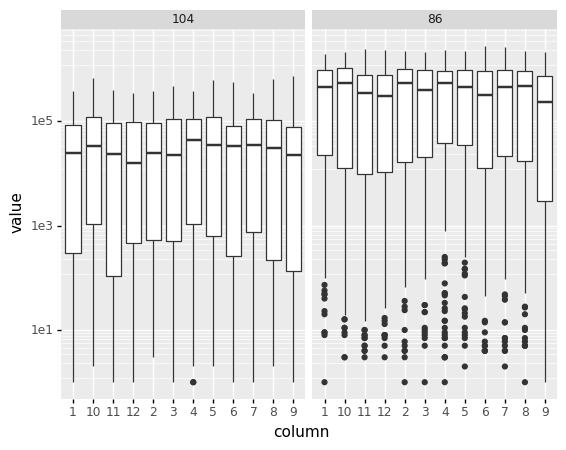

<ggplot: (8788570542499)>

In [15]:
import plotnine as pn

exp_data = data[data["condition"] == "experimental"]
# column_cat = pd.Categorical(exp_data['column'], categories=list(range(1,13)))
# exp_data = exp_data.assign(column_cat=column_cat)

(
    pn.ggplot(exp_data, pn.aes("column", "value"))
    + pn.geom_boxplot()
    + pn.facet_wrap("peptide")
    + pn.scale_y_log10()
)


Doesn't look like there is a column dependence on the experimental data. Maybe on the positive controls only?

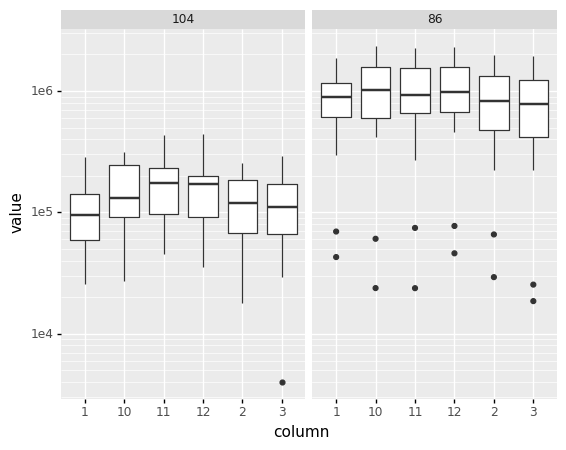

<ggplot: (8788570545725)>

In [16]:
pos_data = data[data["condition"] == "positive"]

(
    pn.ggplot(pos_data, pn.aes("column", "value"))
    + pn.geom_boxplot()
    + pn.facet_wrap("peptide")
    + pn.scale_y_log10()
)


In the case of WT, there is certainly a slight dependence on column, but probably not significant.

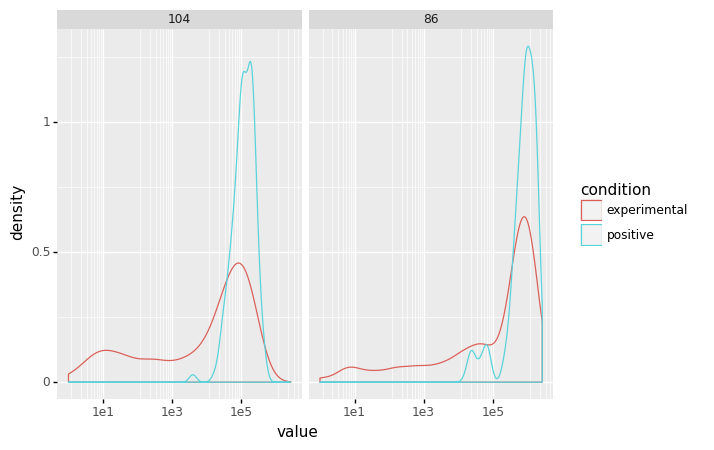

<ggplot: (8788553308064)>

In [4]:
(
    pn.ggplot(data, pn.aes("value", color="condition"))
    + pn.geom_density()
    # + pn.geom_dotplot()
    + pn.facet_wrap("peptide")
    + pn.scale_x_log10()
)


Brightness of the peptides. Overall, this seems to make a lot of sense.

In [5]:
pivoted["ratio"] = pivoted["value", "86"] / pivoted["value", "104"]
pivoted


plate_number row column     condition   value                ratio
peptide                                           104       86            
0                  1   A      1      positive   46458   841605   18.115395
1                  1   A     10  experimental   41399   960919   23.211165
2                  1   A     11  experimental     490    71801  146.532653
3                  1   A     12  experimental    2263   214261   94.680071
4                  1   A      2      positive   17825   610292   34.237980
..               ...  ..    ...           ...     ...      ...         ...
187                2   H      5  experimental  229539  1829951    7.972288
188                2   H      6  experimental   97757  1677037   17.155160
189                2   H      7  experimental  115329  1841453   15.966955
190                2   H      8  experimental   24340  1018006   41.824404
191                2   H      9  experimental   48297  1621927   33.582355

[2112 rows x 7 columns]

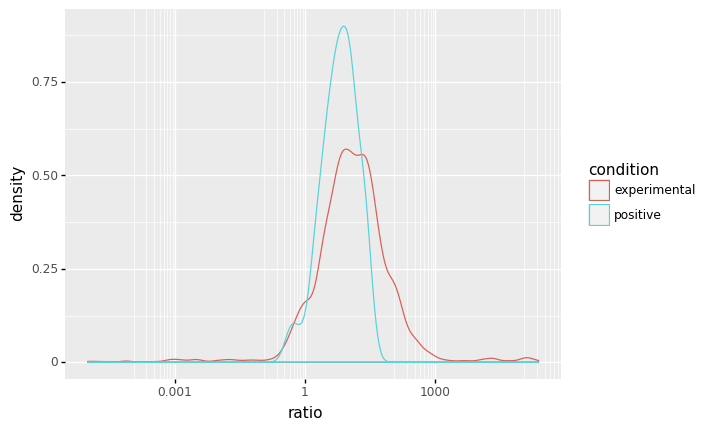

<ggplot: (8788569966472)>

In [6]:
(
    pn.ggplot(pivoted, pn.aes("ratio", color="condition"))
    + pn.geom_density()
    + pn.scale_x_log10()
)


Selectivity. This is interesting. It looks like overall the C8 library prefers 86 to 104 (greater than 1) even more than WT. Not sure how to interpret these plots in the light of the library being ~25% WT.

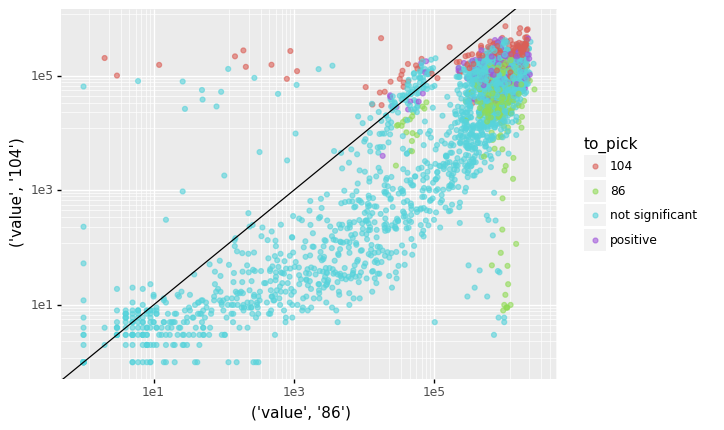

<ggplot: (8788586609478)>

In [61]:
(
    pn.ggplot(
        pivoted,
        pn.aes(pivoted["value", "86"], pivoted["value", "104"], color="to_pick"),
    )
    + pn.geom_point(alpha=.6)
    + pn.scale_x_log10()
    + pn.scale_y_log10()
    + pn.geom_abline(intercept=0, slope=1)
)


/Users/rathbunc/opt/anaconda3/envs/general-ml/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/Users/rathbunc/opt/anaconda3/envs/general-ml/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
/Users/rathbunc/opt/anaconda3/envs/general-ml/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 175 rows containing non-finite values.


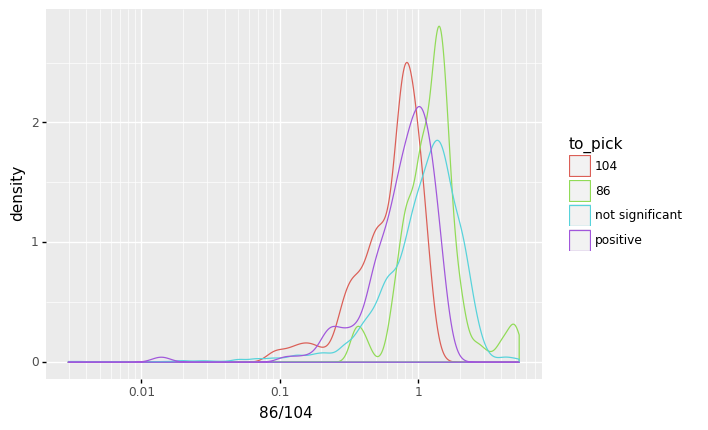

<ggplot: (8788538407930)>

In [39]:
(
    pn.ggplot(pivoted, pn.aes("86/104", color="to_pick"))
    + pn.geom_density()
    + pn.scale_x_log10()
)


This is interesting. Shows that we did (on average) have hits that preferred 104 to 86 (on the left of 1). But you can still see that the C8 library preferred 86 a bit more.

In [51]:
from collections import Counter

c = Counter(pivoted["to_pick"])
print(
    "Total screened mutants:",
    len(pivoted["to_pick"][pivoted["to_pick"] != "positive"]),
    "\nApproximate amounts picked:",
    c,
)


Total screened mutants: 2250 
Approximate amounts picked: Counter({'not significant': 1797, '86': 251, '104': 202, 'positive': 150})


So it looks like there were ~10% hit rates for each 104 and 86. This seems reasonable. We'll see if this is actually converging on anything. This means that the depth of the sequencing only really needs to be 5-10x the number of things picked so about 2500. That means with a depth of 50000 for amplicon EZ we could have 50000/2500=20 barcodes??